### Dating app AB-test


The dating app team has developed a new algorithm to improve the quality of the service. 
An AB test was conducted to compare the old algorithm with the new one. The users were divided into two groups: group 0 used the app with the old algorithm, while group 1 used the application with the new algorithm to search for profiles. 

Evaluate whether the new algorithm has improved the service quality. Select the metrics that are responsible for service quality and statistically compare these metrics between the two groups. 

The data provided contains the logs of users' interactions. For each pair of users, you can see which group they have been assigned to and whether they had a match. 

Your conclusion should provide an analytical evaluation of whether we should use the new algorithm for all users.

In [44]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
df = pd.read_csv('dating_data.csv')

#### Explorational analyziz

In [46]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [47]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [48]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

_We have no missing values_

In [49]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [50]:
if np.array_equal(np.sort(df.user_id_1.unique()), np.sort(df.user_id_2.unique())):
    print('Both groups have same uids')
else:
    print('Uids differ between groups')

Both groups have same uids


Let's check user's activity between groups

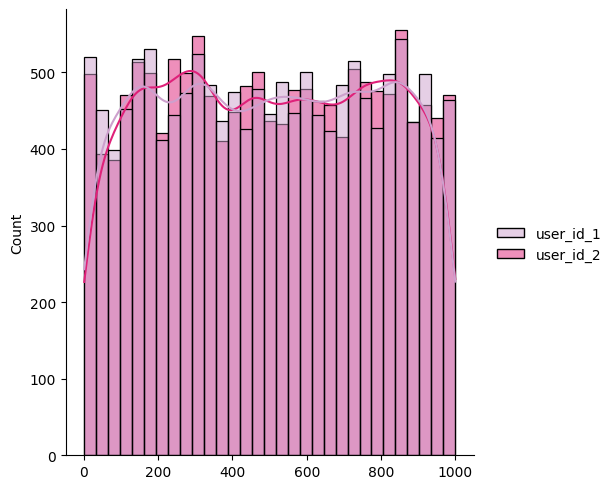

In [51]:
sns.displot(df[['user_id_1', 'user_id_2']], kde=True, palette='PuRd')
plt.show()

_All users are similarly active in both groups_

Let's check if groups have any intersections

In [52]:
gr1_id1 = np.sort(df[df.group == 1].user_id_1.unique())
gr0_id1 = np.sort(df[df.group == 0].user_id_1.unique())
gr1_id2 = np.sort(df[df.group == 1].user_id_2.unique())
gr0_id2 = np.sort(df[df.group == 0].user_id_2.unique())

In [53]:
if ((np.array_equal(gr1_id1, gr1_id2) and np.array_equal(gr0_id1, gr0_id2)) and 
    not(np.array_equal(gr1_id1, gr0_id2) or np.array_equal(gr1_id2, gr0_id1))):
    print('Groups do not have intersections. All users match within their group only')
else:
    print('Groups have intersects. AB-test disegn was not correct')

Groups do not have intersections. All users match within their group only


### User Activity

In [54]:
df[df.group == 1].shape, df[df.group == 0].shape

((9722, 4), (4792, 4))

In [55]:
f'Users from experimental group did {round((9722 - 4792)*100/4792)}% more actions than test group users'

'Users from experimental group did 103% more actions than test group users'

We have an equal number of users in both the control and experimental groups. However, the experimental group has performed twice as many actions as the control group. This suggests that the new algorithm has increased user engagement.

Let's review the activity levels and number of matches in both groups to confirm this.

In [56]:
mapping = {0: 'Current algorythm', 1: 'New algorythm'}
df['group_text'] = df['group'].map(mapping)

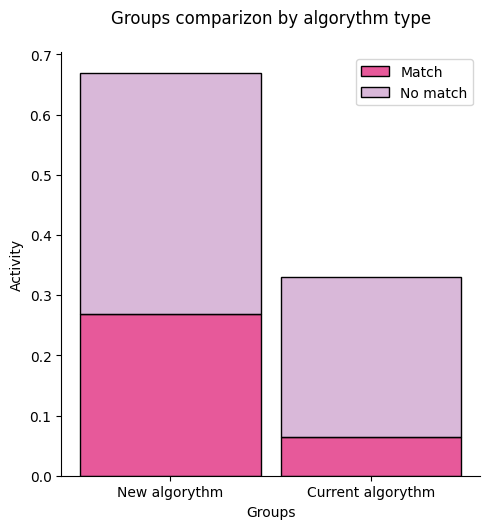

In [57]:
sns.displot(data=df , x='group_text', hue='is_match', palette='PuRd', 
            shrink=0.9, common_norm=True, stat='density', multiple="stack", legend=False)
plt.title('Groups comparizon by algorythm type\n')
plt.xlabel('Groups')
plt.ylabel('Activity')
plt.legend(['Match','No match'])
plt.show()

In [58]:
df['user_act'] = df.groupby(['group', 'user_id_1']).user_id_1.transform('count')

In [59]:
df.head()

,user_id_1,user_id_2,group,is_match,group_text,user_act
0,79,91,1,1,New algorythm,11
1,716,353,1,1,New algorythm,20
2,423,677,0,0,Current algorythm,12
3,658,165,1,1,New algorythm,18
4,969,155,0,1,Current algorythm,11


In [60]:
matches_quant = df.groupby('group', as_index=False).agg({'user_id_1':'count', 'user_id_2':'nunique'}) \
                    .rename(columns = {'user_id_1':'iteractions', 'user_id_2':'users'})
matches_quant['user_iter'] = matches_quant.iteractions / matches_quant.users
matches_quant

,group,iteractions,users,user_iter
0,0,4792,501,9.564870
1,1,9722,499,19.482966


The control group has less than 10 actions per user, while the test group has almost 20. 

The test group is twice as active as the control group.

Let's check the statistical difference between groups using a t-test.
- Null hypothesis: There's no statistical difference in user actions' means between the two groups
- p-value: 0.05

In [61]:
pg.ttest(x=df[df.group==0].user_act, y=df[df.group==1].user_act)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-180.267609,9323.481285,two-sided,0.0,"[-9.5, -9.3]",3.209333,inf,1.0


- The p-value of 0 indicates that the difference between the two group means is doubtful to occur by chance, assuming the null hypothesis (that the means are equal) is accurate. Therefore, we can reject the null hypothesis and conclude that there is a statistically significant difference between the two group means.
- The 95% CI of [-9.5, -9.3] means that we are 95% confident that the actual difference between the two population means lies within this interval. Since the interval does not include zero, it also supports the conclusion that the two group means are significantly different.
- The negative sign of the interval means that the control group has a lower mean than the test group, and the magnitude of the difference is between 9.3 and 9.5 actions per user, which corresponds with our calculations

Improving user experience along with increasing the user's activity in the app is crucial to increasing satisfaction, achieving goals, and boosting the number of matches.

### Matches

Let's see if matches were affected by the new algorithm

In [62]:
matches_pers = pd.crosstab(df.group, df.is_match, normalize='index')
matches_pers = matches_pers.reset_index(drop=True).rename_axis(None, axis=1).reset_index() \
                             .rename(columns={'index':'Groups', 0: 'No_match', 1: 'Match'})
matches_pers

,Groups,No_match,Match
0,0,0.805092,0.194908
1,1,0.597922,0.402078


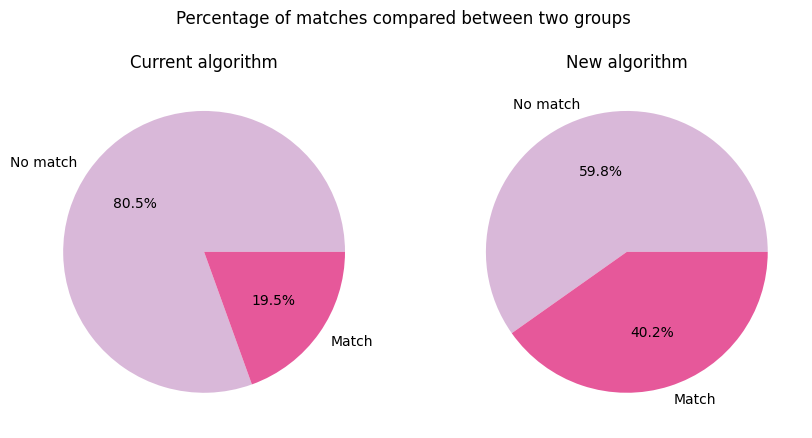

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
labels = ['No match', 'Match']
colors = ['#d9b8d9', '#e6589a']

for i, group in enumerate(matches_pers['Groups']):
    ax[i].pie(matches_pers[matches_pers['Groups'] == group][['No_match', 'Match']].values.flatten(),
              labels=labels, autopct='%1.1f%%', colors=colors)
ax[0].set_title('Current algorithm')
ax[1].set_title('New algorithm')

plt.suptitle('Percentage of matches compared between two groups')

plt.show()

The test group has 40% matches, while the control group has only 20%

Let's check the statistical difference between groups using a t-test.
- Null hypothesis: The means of matches are equal in both groups
- p-value: 0.05

In [71]:
pg.ttest(x=df[df.group==0].is_match, y=df[df.group==1].is_match)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-27.32452,11520.535231,two-sided,2.438263e-159,"[-0.22, -0.19]",0.449019,1.737e+156,1.0


- The p-value close to 0 indicates that the difference between the two group means in matches is highly unlikely to occur by chance, assuming the null hypothesis (that the means are equal) is accurate. Therefore, we can **reject the null hypothesis and conclude that there is a statistically significant difference between the two group means in matches.**
- The 95% CI of [-0.22, -0.19] means that we are 95% confident that the actual difference between the two population means lies within this interval. Since the interval does not include zero, it also supports the conclusion that the two group means are significantly different.
- The negative sign of the interval means that the **control group has a lower mean than the test group**, and the magnitude of the difference is around 0.2 actions per user, which corresponds with our calculations

Therefore, we can reject the null hypothesis and conclude that there is a statistically significant difference between matches in these groups.

#### AMU

Let's also check average number of matches per user in both groups

In [66]:
matches_per_user = df.query('is_match == 1').groupby(['group', 'user_id_1'], as_index=False)\
                      .size().rename(columns={'user_id_1':'users', 'size':'matches'})
matches_per_user.head()

,group,users,matches
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1


In [67]:
matches_per_user.groupby('group').matches.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
0,422.0,2.213270,1.194610,1.0,1.0,2.0,3.0,9.0
1,498.0,7.849398,2.459206,2.0,6.0,8.0,9.0,16.0


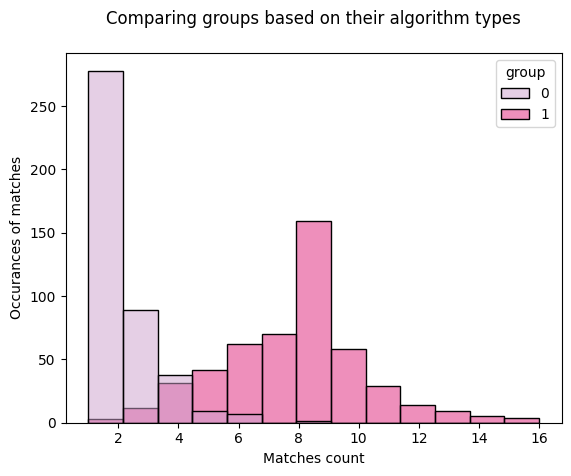

In [68]:
sns.histplot(data=matches_per_user, x='matches', hue='group', palette='PuRd')
plt.title('Comparing groups based on their algorithm types\n')
plt.xlabel('Matches count')
plt.ylabel('Occurances of matches')
plt.show()

Visualization shows significant difference between the disctribution on matches between groups:
- control group: most of the users have 1-2 matches
- test group: number of matches is normally distributed within users with max in 8-9 matches per user

Let's check statistical difference between groups using t-test.
- Null hypothesis: There's no statistical difference in means between two groups' matches
- p-value: 0.05

In [69]:
pg.ttest(x=matches_per_user.query('group==0')['matches'], y=matches_per_user.query('group==1')['matches'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


- The p-value close to 0 indicates that the difference between the two group means is extremely unlikely to occur by chance, assuming the null hypothesis (that the means are equal) is true. Therefore, **we can reject the null hypothesis and conclude that there is a statistically significant difference between the two group means**.
- The 95% CI of [-5.88, -5.39] means that we are **95% confident that the true difference between the two population means lies within this interval**. Since the interval does not include zero, it also supports the conclusion that the two group means are significantly different.
- The negative sign of the interval means that the **control group has a lower mean than the test group**, and the magnitude of the difference is between 5.3 and 5.8 actions per user, which corresponds with our calculations

### Summary

We conducted an ab-test to compare the performance of the new algorithm for questionnaire retrieval with the current one. We randomly assigned users to two groups: test group 1 received the new algorithm, and test group 2 received the current algorithm. We measured the following metrics for each group:
- **User activity**: the number of questionnaires completed by the users
- **Total number of matches**: the number of users who found at least one match based on their questionnaire responses
- **Average number of matches per user**: the mean number of matches found by each user

The results of the ab-test showed that the new algorithm significantly improved all three metrics compared to the current algorithm. The test group 1 had:
- **A +103% increase in user activity** (from ~10 to ~20 questionnaires per day)
- **A +100% increase in the total number of matches** (from ~20% to ~40% matches per group)
- **A +400% increase in the average number of matches per user** (from ~2 to ~8 matches per user)

These results indicate that the new algorithm is more effective and efficient in retrieving relevant questionnaires for the users, leading to higher engagement and satisfaction. Therefore, **we can recommend that the new algorithm be applied to all users.** 